In [1]:
# Last change: FA, Feb 22 2022

# NGC 1605 is not a binary cluster
### Analysing the putative "old binary cluster" of [Camargo (2021, ApJ)](https://ui.adsabs.harvard.edu/abs/2021arXiv210914664C/abstract) with Gaia EDR3 and blind clustering

In [182]:
import numpy as np
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde
from astropy.stats import bayesian_blocks, histogram
import seaborn as sns
import os.path

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

import hdbscan
import seaborn as sns
import sklearn.cluster

## Preparing the Gaia  EDR3 sample

Select stars in the vicinity of the cluster from the [Gaia archive](https://gea.esac.esa.int/archive/):

In [231]:
data = Table.read("./data/ngc_1605_region_gaiaedr3.fits")

Alternatively, we can use astroquery to perform the query on the fly:

# Membership analyses for NGC 1605

We test various methods to determine membership for the cluster in question and demonstrate that there is no solid evidence for this object hosting multiple populations:

## 1. DBSCAN - Castro-Ginard et al. (2022) membership list

[Castro-Ginard et al. (2022)](https://ui.adsabs.harvard.edu/abs/2021arXiv211101819C/abstract) carried out a blind search for open-cluster-like overdensities in the Gaia EDR3 data (using five dimensions: ${\tt ra, dec, pmra, pmdec, parallax}$). They find a single overdensity in the field of NGC 1605:

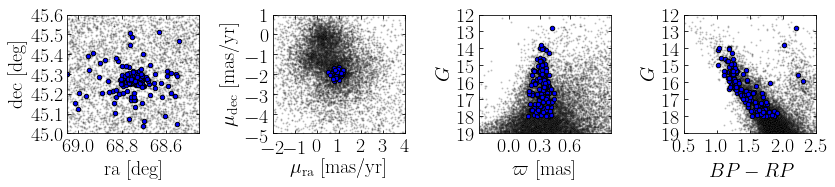

In [270]:
castroginard_2022_ngc1605 = Table.read("./data/NGC1605_dbscan.csv", format="csv")
dbscan_members            = castroginard_2022_ngc1605["source_id"]

f = plt.figure(figsize=(12, 3))
axlist= [141, 142, 143, 144]
x_axes= ["ra", "pmra", "parallax", "bp_rp"]
y_axes= ["dec", "pmdec", "phot_g_mean_mag", "phot_g_mean_mag"]
lims  = [[69.05, 68.45, 45.0, 45.6], [-2, 4, -5, 1], [-.3, 1, 19, 12], [.5, 2.5, 19, 12] ]
x_labels= ["ra [deg]", r"$\mu_{\rm ra}$ [mas/yr]", r"$\varpi$ [mas]", "$BP-RP$"]
y_labels= ["dec [deg]", r"$\mu_{\rm dec}$ [mas/yr]", "$G$", "$G$"]
x_ticks= [[69,68.8,68.6], [], [0,0.3,0.6]]

for jj in [0,1,2,3]: 
    ax = f.add_subplot(plt.Subplot(f, axlist[jj]))
    plt.scatter(data[x_axes[jj]], data[y_axes[jj]], s=1, c="grey", alpha=0.2)
    for id in dbscan_members:
        plt.scatter(data[data["source_id"]==id][x_axes[jj]], 
                    data[data["source_id"]==id][y_axes[jj]], c="blue")
    if jj in [0,2]:
        ax.set_xticks(x_ticks[jj])
    plt.axis(lims[jj])
    ax.set_xlabel(x_labels[jj])
    ax.set_ylabel(y_labels[jj])
plt.tight_layout()
plt.savefig("./im/ngc1605_dbscan_analysis.png", dpi=200)

There is no hint for a double sequence in the CMD, only a noisy main sequence (due to differential extinction within the cluster) and a few field contaminants that are much redder.

The left plot also shows little evidence of the tidal features reported by [Camargo (2021)](https://ui.adsabs.harvard.edu/abs/2021arXiv210914664C/abstract).

## 2. pyUPMASK membership analysis

We also tested the algorithm pyUPMASK ([Pera et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...650A.109P/abstract)) using the default parameters and a membership probability cut $P_{memb}>0.95$. The results are very similar (but go to fainter magnitudes):

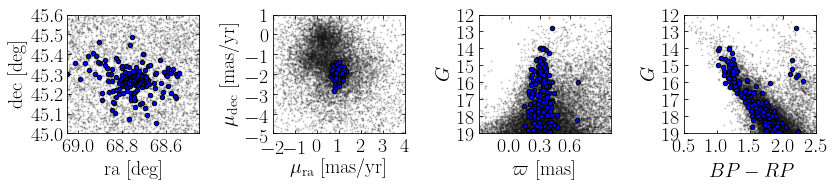

In [271]:
pyupmask_ngc1605 = Table.read("./data/ngc_1605_pyupmask_pm95.fits", format="fits")
pyupmask_members = pyupmask_ngc1605["source_id"]

f = plt.figure(figsize=(12, 3))
for jj in [0,1,2,3]: 
    ax = f.add_subplot(plt.Subplot(f, axlist[jj]))
    plt.scatter(data[x_axes[jj]], data[y_axes[jj]], s=1, c="grey", alpha=0.2)
    for id in pyupmask_members:
        plt.scatter(data[data["source_id"]==id][x_axes[jj]], 
                    data[data["source_id"]==id][y_axes[jj]], c="blue")
    if jj in [0,2]:
        ax.set_xticks(x_ticks[jj])
    plt.axis(lims[jj])
    ax.set_xlabel(x_labels[jj])
    ax.set_ylabel(y_labels[jj])
plt.tight_layout()
plt.savefig("./im/ngc1605_pyupmask_analysis.png", dpi=200)

## 3. HDBSCAN Clustering


HDBSCAN ([McInnes et al. 2017](https://ui.adsabs.harvard.edu/abs/2017JOSS....2..205M/abstract)) is the hierarchical version of DBSCAN and as such has some advantages over DBSCAN. [Hunt & Reffert (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...646A.104H/abstract) demonstrated that it can outperform other clustering algorithms for automated open cluster searches, at least in terms of completeness.

Here we demonstrate that also HDBSCAN returns the presence of two candidate clusters in the field of NGC 1605 (but the second one is not contained in the field studied by Camargo (2021)):

In [199]:
# get the five-dimensional astrometric parameter space
X = np.c_[ np.array(data["ra"]), np.array(data["dec"]), np.array(data["pmra"]), 
           np.array(data["pmdec"]), np.array(data["parallax"]) ]
# rescale it so that a Euclidean metric makes more sense:
X = ( X - np.mean(X, axis=0) ) / np.std(X, axis=0)

Now we run HDBSCAN. After [playing a bit with the main HDBSCAN parameters](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-min-samples) (mostly ${\tt min\_cluster\_size}$ and ${\tt min\_samples}$), we see that we get reliable results and almost always find **either two clusters or none** at all (stars classified as "-1" don't belong to a cluster found by HDBSCAN):

In [200]:
labels     =hdbscan.HDBSCAN(min_cluster_size=10).fit_predict(X)
print("Clustering labels: ", np.unique(labels))

Clustering labels:  [-1  0  1]


In [202]:
labels     =hdbscan.HDBSCAN(min_cluster_size=40).fit_predict(X)
print("Clustering labels: ", np.unique(labels))

Clustering labels:  [-1]


In [216]:
labels     =hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(X)
print("Clustering labels: ", np.unique(labels))

Clustering labels:  [-1  0  1]


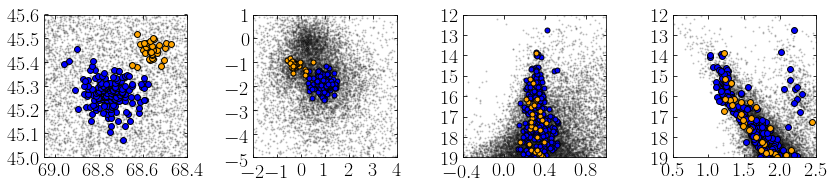

In [272]:
f = plt.figure(figsize=(12, 3))
axlist= [141, 142, 143, 144]
for jj in [0,1,2,3]: 
    ax = f.add_subplot(plt.Subplot(f, axlist[jj]))
    plt.scatter(data[x_axes[jj]], data[y_axes[jj]], s=1, c="grey", alpha=0.2)
    plt.scatter(data[labels==0][x_axes[jj]], data[labels==0][y_axes[jj]], 
                    c=clist[0], s=sizes[jj], label="NGC 1605")
    plt.scatter(data[labels==1][x_axes[jj]], data[labels==1][y_axes[jj]], 
                    c=clist[1], s=sizes[jj], label="Can Batllo 1")
    plt.axis(lims[jj])
    if jj in [0,2]:
        ax.set_xticks(ax.get_xticks()[::2])
plt.tight_layout()
plt.savefig("./im/ngc1605_hdbscan_analysis.png", dpi=200)

### Save the 2 membership lists (if needed)

## 4. Manual analysis

The details of this membership analysis are described in [manual_analysis.md](./manual_analysis.md).
Let's have look at these data & **create Fig. 1 of our Research Note**:

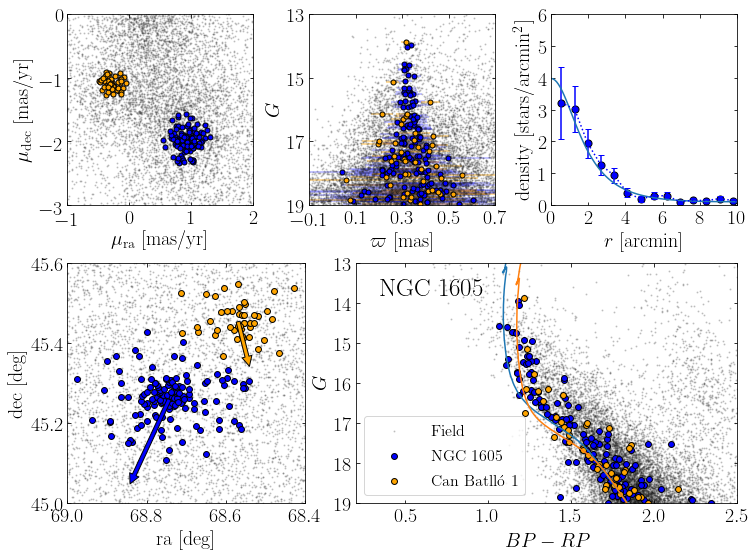

In [357]:
f = plt.figure(figsize=(12, 9))#, tight_layout=True)
#plt.suptitle("HDBSCAN analysis of NGC 1605")
gs = gridspec.GridSpec(10, 3, wspace=.3, hspace=.2)
gs1= gridspec.GridSpec(10, 10, wspace=2.4, hspace=.2)

axlist= [gs1[5:, 0:4], gs[0:4, 0], gs[0:4, 1], gs1[5:, 4:]]#[141, 142, 143, 144]
x_axes= ["ra", "pmra", "parallax", "bp_rp"]
y_axes= ["dec", "pmdec", "phot_g_mean_mag", "phot_g_mean_mag"]
lims  = [[68.97, 68.47, 45.05, 45.55], [-1, 2, -3, 0], [-.1, .7, 19, 13], [.2, 2.5, 19, 13] ]
x_labels= ["ra [deg]", r"$\mu_{\rm ra}$ [mas/yr]", r"$\varpi$ [mas]", "$BP-RP$"]
y_labels= ["dec [deg]", r"$\mu_{\rm dec}$ [mas/yr]", "$G$", "$G$"]
sizes = [35,25,25,35]

for jj in [0,1,2,3]: 
    ax = f.add_subplot(axlist[jj])
    plt.scatter(data[x_axes[jj]], data[y_axes[jj]], s=1, c="grey", alpha=0.2, label="Field")
    if jj==2:
        # add parallax errorbars
        plt.errorbar(data[data["NGC1605_FA"]==1][x_axes[jj]], data[data["NGC1605_FA"]==1][y_axes[jj]], 
                     xerr=data[data["NGC1605_FA"]==1]["parallax_error"], c="b", alpha=0.3, fmt="none", mew=0, zorder=0)
        plt.errorbar(data[data["CanBatllo_FA"]==1][x_axes[jj]], data[data["CanBatllo_FA"]==1][y_axes[jj]], 
                     xerr=data[data["CanBatllo_FA"]==1]["parallax_error"], c="orange", alpha=0.5, fmt="none", mew=0, zorder=0)
    plt.scatter(data[data["NGC1605_FA"]==1][x_axes[jj]], data[data["NGC1605_FA"]==1][y_axes[jj]], 
                    c="b", s=sizes[jj], label="NGC 1605")
    plt.scatter(data[data["CanBatllo_FA"]==1][x_axes[jj]], data[data["CanBatllo_FA"]==1][y_axes[jj]], 
                    c="orange", s=sizes[jj], label=r"Can Batlló 1")
    plt.axis(lims[jj])
    ax.set_xlabel(x_labels[jj])
    ax.set_ylabel(y_labels[jj])
    if jj==0:
        # add proper motion arrows to the centre of the clusters
        x_tail = 68.7405
        y_tail = 45.2641
        x_head = x_tail + 400. * 0.93 / 3600. 
        y_head = y_tail - 400. * 1.98 / 3600.
        arrow = patches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=20, facecolor="blue")
        ax.add_patch(arrow)
        x_tail = 68.5697
        y_tail = 45.4583
        x_head = x_tail - 400. * 0.28 / 3600. 
        y_head = y_tail - 400. * 1.09 / 3600.
        arrow1= patches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=20, facecolor="orange")
        ax.add_patch(arrow1)        
    if jj < 3:
        ax.set_xticks(ax.get_xticks()[::2])
        ax.set_yticks(ax.get_yticks()[::2])
    else:
        ax.legend(loc=3, fontsize=16)
        plt.text(.35, 13.8, "NGC 1605", fontsize=25)
        # Overplot isochrone with chi-by-eye parameters:
        isoc  = Table.read("data/parsec_12s_isochrones.fits")
        import photutils
        AV  = 2.6
        dist= 2.75 # from Bayesian analysis below
        isoc["BPRP_obs"] = photutils.BPRP_obs(isoc["G_BPmag"], isoc["G_RPmag"], AV, 10.**isoc["logTe"])
        isoc["G_obs"]    = photutils.G_obs(isoc["Gmag"], dist, AV, 10.**isoc["logTe"])
        n1605 = isoc[(np.abs(isoc["logAge"]-8.3)<0.01) & (np.abs(isoc["MH"]+0.2)<0.01)]
        plt.plot(n1605["BPRP_obs"],n1605["G_obs"])
        dist= 2.86 # from Bayesian analysis below
        AV  = 2.8
        isoc["BPRP_obs"] = photutils.BPRP_obs(isoc["G_BPmag"], isoc["G_RPmag"], AV, 10.**isoc["logTe"])
        isoc["G_obs"]    = photutils.G_obs(isoc["Gmag"], dist, AV, 10.**isoc["logTe"])
        canbatllo = isoc[(np.abs(isoc["logAge"]-8.25)<0.01) & (np.abs(isoc["MH"]+0.4)<0.01)]
        plt.plot(canbatllo["BPRP_obs"],canbatllo["G_obs"])
# Plot radial density of the HDBSCAN members
ax = f.add_subplot(gs[0:4,2])
# Compute central cluster coordinates
ra_cen, dec_cen = np.mean(data[data["NGC1605_FA"]==1]["ra"]), np.mean(data[data["NGC1605_FA"]==1]["dec"])
# Distance from the cluster centre in arcmin
r = 60. * np.sqrt((data[data["NGC1605_FA"]==1]["ra"]-ra_cen)**2. + (data[data["NGC1605_FA"]==1]["dec"]-dec_cen)**2.)
hist, edges = histogram(r, bins=20)
# compute density
r_points = (edges[:-1]+edges[1:])/2.
r_area   = np.pi * edges[1:]**2. - np.pi * edges[:-1]**2.
r_density= hist / r_area
r_density_err = np.sqrt(hist)/r_area
plt.errorbar(r_points, r_density, yerr=r_density_err, ls=":", c="b")
plt.scatter(r_points, r_density, s=50)
# also plot a King profile (parameters chi by eye:)
x              = np.linspace(0,10,100)
r_c, r_t, floor, rho_cen = 2., 10., .1, 6.
plt.plot(x, floor + rho_cen * (1./np.sqrt(1. + (x/r_c)**2.) - (1. / np.sqrt( 1. + (r_t/r_c)**2.) ))**2. )
plt.axis([0,10,0,6])
ax.set_xlabel(r"$r$ [arcmin]")
ax.set_ylabel(r"density [stars/arcmin$^2$]")
        
plt.subplots_adjust(wspace=.3)
plt.savefig("./im/ngc1605_manual_analysis.png", dpi=200)
plt.show()

## A closer look at the spatial distribution
A bigger plot of the sky distribution and density profile of the NGC 1605 members:

/home/friedel/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


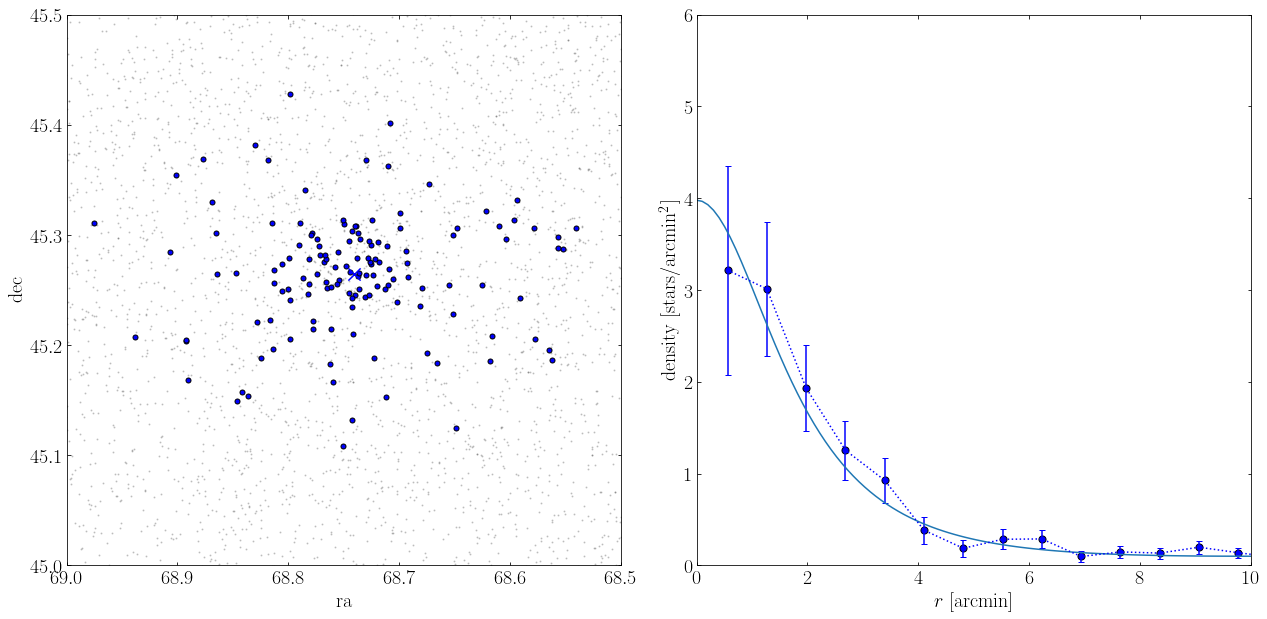

In [276]:
f = plt.figure(figsize=(18, 9), tight_layout=True)
ax = f.add_subplot(121)
plt.scatter(data["ra"], data["dec"], s=1, c="grey", alpha=0.2)
plt.scatter(data[data["NGC1605_FA"]==1]["ra"], data[data["NGC1605_FA"]==1]["dec"], s=25)
plt.scatter(ra_cen, dec_cen, s=150, marker="x")
plt.axis([69.0, 68.5, 45.0, 45.5])
ax.set_xlabel("ra")
ax.set_ylabel("dec")

ax = f.add_subplot(122)
# Plot radial density of the HDBSCAN members
plt.errorbar(r_points, r_density, yerr=r_density_err, ls=":", c="b")
plt.scatter(r_points, r_density, s=50)
# King profile (same as above)
plt.plot(x, floor + rho_cen * (1./np.sqrt(1. + (x/r_c)**2.) - (1. / np.sqrt( 1. + (r_t/r_c)**2.) ))**2. )
plt.axis([0,10,0,6])
ax.set_xlabel(r"$r$ [arcmin]")
ax.set_ylabel(r"density [stars/arcmin$^2$]")
plt.savefig("./im/ngc1605_densityprofile.png", dpi=200)
plt.show()

## Mean cluster parameters

In [318]:
ra_cen, dec_cen = np.mean(data[data["NGC1605_FA"]==1]["ra"]), np.mean(data[data["NGC1605_FA"]==1]["dec"])
print("NGC 1605")
print("Mean RA:", np.round(ra_cen, 4), "Mean DEC:", np.round(dec_cen, 4))
pmra_cen, pmdec_cen = np.mean(data[data["NGC1605_FA"]==1]["pmra"]), np.mean(data[data["NGC1605_FA"]==1]["pmdec"])
print("Mean pmra:", np.round(pmra_cen,2), "Mean pmdec:", np.round(pmdec_cen, 2))
print("Mean RV:", np.round(np.mean(data[data["NGC1605_FA"]==1]["dr2_radial_velocity"]),2) )

ra_cen, dec_cen = np.mean(data[data["CanBatllo_FA"]==1]["ra"]), np.mean(data[data["CanBatllo_FA"]==1]["dec"])
print("Can Batllo 1")
print("Mean RA:", np.round(ra_cen, 4), "Mean DEC:", np.round(dec_cen, 4))
pmra_cen, pmdec_cen = np.mean(data[data["CanBatllo_FA"]==1]["pmra"]), np.mean(data[data["CanBatllo_FA"]==1]["pmdec"])
print("Mean pmra:", np.round(pmra_cen,2), "Mean pmdec:", np.round(pmdec_cen, 2))
print("Mean RV:", np.round(np.mean(data[data["CanBatllo_FA"]==1]["dr2_radial_velocity"]),2) )


NGC 1605
Mean RA: 68.7405 Mean DEC: 45.2641
Mean pmra: 0.93 Mean pmdec: -1.98
Mean RV: nan
Can Batllo 1
Mean RA: 68.5697 Mean DEC: 45.4583
Mean pmra: -0.28 Mean pmdec: -1.09
Mean RV: nan


### Parallax corrections

Now let's determine the (zero-point corrected) parallax of NGC 1605 and the new OC candidate. First determine the parallax zeropoint for all stars in the field (following [Lindegren et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...4L/abstract) & shamelessly copying code from the [tutorial of Pau Ramos](https://gitlab.com/icc-ub/public/gaiadr3_zeropoint/-/tree/master/)):

In [238]:
import zpt
zpt.load_tables()
zpvals = zpt.get_zpt(data['phot_g_mean_mag'], data['nu_eff_used_in_astrometry'], 
                     data['pseudocolour'], data['ecl_lat'], data['astrometric_params_solved'])

/home/friedel/Desktop/ngc1605/zpt.py:236: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  UserWarning)


Now correct for it and determine the corrected mean parallax (and its uncertainty) for the two found clusters:

In [286]:
parallax_corr = data["parallax"] - zpvals
pi_ngc_1605   = np.mean(parallax_corr[data["NGC1605_FA"]==1])
e_pi_ngc_1605 = np.std(parallax_corr[data["NGC1605_FA"]==1]) / np.sqrt(np.sum(data["NGC1605_FA"]==1))
pi_ngc_new    = np.mean(parallax_corr[data["CanBatllo_FA"]==1])
e_pi_ngc_new  = np.std(parallax_corr[data["CanBatllo_FA"]==1]) / np.sqrt(np.sum(data["CanBatllo_FA"]==1))

print("NGC 1605 parallax:", np.round(np.mean(data["parallax"][data["NGC1605_FA"]==1]),3))
print("NGC 1605 corrected parallax:", np.round(pi_ngc_1605,3), r"+-", np.round(e_pi_ngc_1605,3))
print("Can Batllo 1 parallax:", np.round(np.mean(data["parallax"][data["CanBatllo_FA"]==1]),3))
print("Can Batllo 1 corrected parallax:", np.round(pi_ngc_new,3), r"+-", np.round(e_pi_ngc_new,3))

NGC 1605 parallax: 0.334
NGC 1605 corrected parallax: 0.364 +- 0.007
Can Batllo 1 parallax: 0.333
Can Batllo 1 corrected parallax: 0.361 +- 0.015
Assumed zeropoint uncertainty: 0.005 mas (Lindegren et al. 2021)


### Bayesian distances

We calclulate the distance to the clusters, assuming negligible parallax correlations and cluster extent, following [this tutorial](https://github.com/agabrown/astrometry-inference-tutorials/blob/master/multiple-source/Distance_inference-multiple_sources.ipynb): 

Assumed zeropoint uncertainty: 0.005 mas (Lindegren et al. 2021)
Distance NGC 1605: 2.753 +- 0.044 kpc
Distance Can Batllo 1: 2.863 +- 0.095 kpc


/home/friedel/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


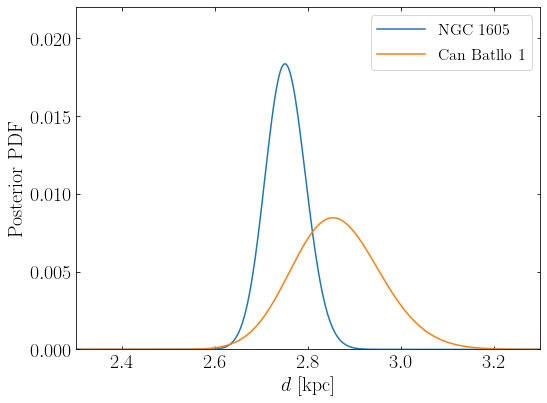

In [288]:
# Array of possible distances
d     = np.linspace(2., 4., 1000)
# Prior
L     = 3.0
prior = np.piecewise(d, [d < 0, d >= 0], [0, 1/(2*L**3.) * d**2. * np.exp(- d / L )])
# Parallax data
pi    = parallax_corr[data["NGC1605_FA"]==1]
sigpi = data["parallax_error"][data["NGC1605_FA"]==1]
sigpi_sys = 0.005
print("Assumed parallax zeropoint uncertainty: 0.005 mas (Lindegren et al. 2021)")
# Likelihood (simple product of Gaussians)
likeli_ngc1605  = np.prod(1/np.sqrt(2*np.pi*(sigpi+sigpi_sys)**2.) * \
                 np.exp(-1/(2*(sigpi+sigpi_sys)**2.) * (pi[np.newaxis, :] - 1./d[:, np.newaxis])**2. ), axis=1)
# Normalised posterior
post_ngc1605    = prior * likeli_ngc1605 / np.sum(prior * likeli_ngc1605)
# Statistics
mean_ngc1605    = np.average(d, weights=post_ngc1605)
sigd_ngc1605    = np.sqrt(np.average((d-mean_ngc1605)**2, weights=post_ngc1605))
# Fast and numerically precise:
print("Distance NGC 1605:", np.round(mean_ngc1605,3), "+-", np.round(sigd_ngc1605,3), "kpc")
# Now the same for Can Batllo
pi    = parallax_corr[data["CanBatllo_FA"]==1]
sigpi = data["parallax_error"][data["CanBatllo_FA"]==1]
likeli_canbatllo= np.prod(1/np.sqrt(2*np.pi*(sigpi+sigpi_sys)**2.) * \
                 np.exp(-1/(2*(sigpi+sigpi_sys)**2.) * (pi[np.newaxis, :] - 1./d[:, np.newaxis])**2. ), axis=1)
post_canbatllo    = prior * likeli_canbatllo / np.sum(prior * likeli_canbatllo)
mean_canbatllo  = np.average(d, weights=post_canbatllo)
sigd_canbatllo  = np.sqrt(np.average((d-mean_canbatllo)**2, weights=post_canbatllo))
print("Distance Can Batllo 1:", np.round(mean_canbatllo,3), "+-", np.round(sigd_canbatllo,3), "kpc")
# Plot the posteriors
f = plt.figure(figsize=(8, 6), tight_layout=True)
ax = f.add_subplot(111)
plt.plot(d, post_ngc1605, label="NGC 1605")
plt.plot(d, post_canbatllo, label="Can Batllo 1")
plt.axis([2.3, 3.3,0, .022])
ax.set_xlabel(r"$d$ [kpc]")
ax.set_ylabel(r"Posterior PDF")
ax.legend(fontsize=16)
plt.savefig("./im/ngc1605_distances.png", dpi=200)
plt.show()

### Astrophysical parameters

We check out the astrophysical parameters from StarHorse2021 for the cluster region. Please remember to take these parameters with a grain of salt - they were computed under the premise of treating field stars! 

In [298]:
starhorse_results = Table.read("./data/SH2021_results_NGC1605reg.fits", format="fits")
# Crossmatch with the membership lists
sh_canbatllo = astropy.table.join(data[data["CanBatllo_FA"]==1], starhorse_results, keys=["source_id"])
sh_ngc1605   = astropy.table.join(data[data["NGC1605_FA"]==1], starhorse_results, keys=["source_id"])

In [314]:
print("mean AV NGC 1605:  ", np.round(np.mean(sh_ngc1605["av50"][sh_ngc1605["sh_outflag"]=="0000"]),2),
      "+-",                  np.round(np.std(sh_ngc1605["av50"][sh_ngc1605["sh_outflag"]=="0000"])/np.sqrt(len(sh_ngc1605)),2))
print("mean AV Can Batllo:", np.round(np.mean(sh_canbatllo["av50"][sh_canbatllo["sh_outflag"]=="0000"]),2),
      "+-",                  np.round(np.std(sh_canbatllo["av50"][sh_canbatllo["sh_outflag"]=="0000"])/np.sqrt(len(sh_canbatllo)),2))

mean AV NGC 1605:   2.3 +- 0.03
mean AV Can Batllo: 2.45 +- 0.05


In [315]:
print("mean metallicity NGC 1605:  ", np.round(np.mean(sh_ngc1605["met50"][sh_ngc1605["sh_outflag"]=="0000"]),2),
      "+-",                           np.round(np.std(sh_ngc1605["met50"][sh_ngc1605["sh_outflag"]=="0000"])/np.sqrt(len(sh_ngc1605)),2))
print("mean metallicity Can Batllo:", np.round(np.mean(sh_canbatllo["met50"][sh_canbatllo["sh_outflag"]=="0000"]),2),
      "+-",                           np.round(np.std(sh_canbatllo["met50"][sh_canbatllo["sh_outflag"]=="0000"])/np.sqrt(len(sh_canbatllo)),2))

mean metallicity NGC 1605:   -0.08 +- 0.02
mean metallicity Can Batllo: -0.14 +- 0.04


## Bonus: Hyperparameter tests and other clustering algorithms (for those who want to play)

If we want to play with other clustering algorithms (especially the ones included in scikit-learn), we can define this little function:

In [14]:
from time import time
def plot_clusters_5d(data, algorithm, args, kwds, savefig=None):
    """
    Produces 4x4 2D plots for the chosen HealPix cell
    """
    # costum axis ranges
    axranges = [[], [], [-5,5], [-8,2], [-.5,1]]
    # Run clustering
    start_time = time()
    labels     = algorithm(*args, **kwds).fit_predict(data)
    labels = np.array( labels )
    howmany = np.unique(labels)
    print("Labels:", howmany)
    # Start plotting
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    mask = (labels >= 0)
    colors = np.array([palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels])
    axlabels = ["ra", "dec", r"$\mu_{\rm ra}$", r"$\mu_{\rm dec}$", r"$\varpi$"]
    f = plt.figure( figsize=(12,12))
    plt.suptitle('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    gs = gridspec.GridSpec(4,4)
    gs.update(left=0.1, right=.95, top=.95, bottom=.1, wspace=.05, hspace=.05)
    for ii in howmany:
        if ii < 0:
            pass
        else:
            print("Cluster", ii, ":", np.sum(labels==howmany[ii]), "stars")
    end_time   = time()
    for ii in range(4):
        for jj in range(4):
            if ii>=jj:
                ax = plt.Subplot(f, gs[ii,jj])
                f.add_subplot(ax)
                plt.scatter(data.T[jj], data.T[ii+1], c=colors, s=1, alpha=0.1)
                if np.sum(mask)>0:
                    plt.scatter(data.T[jj][mask], data.T[ii+1][mask], c=colors[mask], alpha=1,
                                lw=0, s=10)
                frame = plt.gca()
                # Beautify axes:
                if ii == 3:
                    ax.set_xlabel(axlabels[jj], fontsize=15)
                else:
                    frame.axes.get_xaxis().set_visible(False)
                if jj == 0:
                    ax.set_ylabel(axlabels[ii+1], fontsize=15)
                else:
                    frame.axes.get_yaxis().set_visible(False)
                if jj>1:
                    plt.xlim(axranges[jj])
                if ii>0:
                    plt.ylim(axranges[ii+1])
    print('Clustering took {:.2f} s'.format(end_time - start_time))
    if savefig!=None:
        plt.savefig(savefig, dpi=200)
    plt.show()


And then, for example, modify our HDBSCAN analysis. Now we look at the **normalised** 5D parameter space and use a smaller min_cluster_size:

Labels: [-1  0  1  2]
Cluster 0 : 10779 stars
Cluster 1 : 17 stars
Cluster 2 : 209 stars
Clustering took 0.60 s


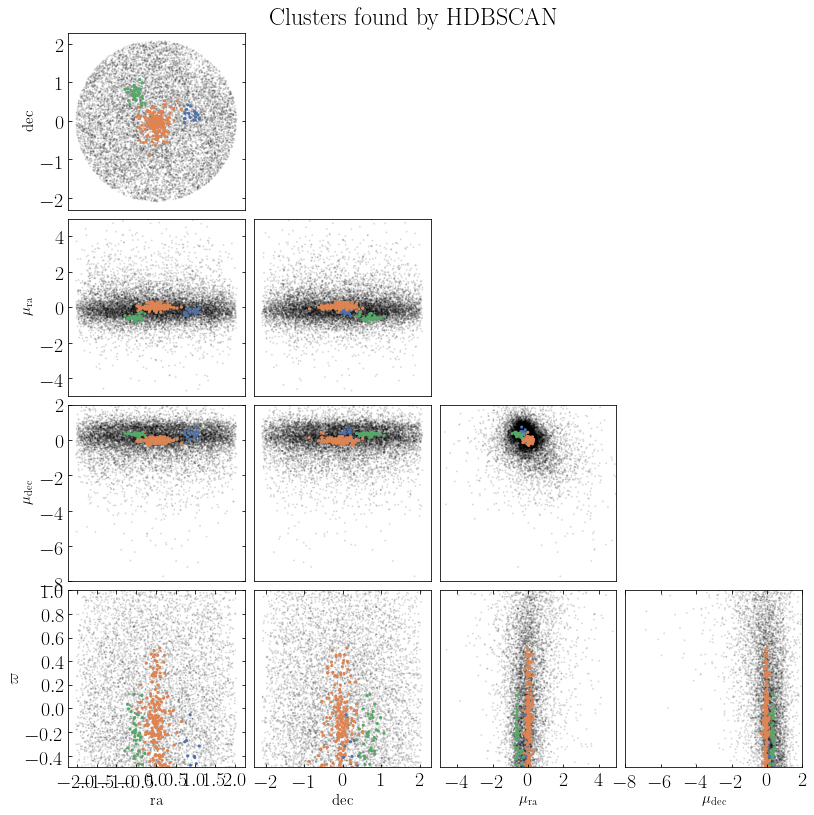

In [15]:
plot_clusters_5d(X, hdbscan.HDBSCAN, (), {'min_cluster_size':17, 'cluster_selection_epsilon':0.01})

Now we have found another overdensity - with negative parallax, however... and not at all robust to parameter changes.